Import Required Libraries

In [6]:
import pandas as pd
import pandas as pd
import numpy as np
import re
import recordlinkage
import networkx as nx

Load the Parquet File

In [7]:
df = pd.read_parquet('veridion.snappy.parquet', engine='pyarrow')

print("Data loaded. Shape:", df.shape)
print(df.info())

Data loaded. Shape: (33446, 75)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33446 entries, 0 to 33445
Data columns (total 75 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   company_name                  32617 non-null  object
 1   company_legal_names           6890 non-null   object
 2   company_commercial_names      28121 non-null  object
 3   main_country_code             31415 non-null  object
 4   main_country                  31415 non-null  object
 5   main_region                   30112 non-null  object
 6   main_city_district            5979 non-null   object
 7   main_city                     29602 non-null  object
 8   main_postcode                 23820 non-null  object
 9   main_street                   19979 non-null  object
 10  main_street_number            17034 non-null  object
 11  main_latitude                 17031 non-null  object
 12  main_longitude                17031 non-nu

Data Cleaning & Standardization

In [8]:
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower().strip()
    text = re.sub(r'[\.,-\/#!$%\^&\*;:{}=\-_`~()]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

# Clean company names.
df['clean_company_name'] = df['company_name'].apply(clean_text)
df['clean_company_legal_names'] = df['company_legal_names'].apply(clean_text)
df['clean_company_commercial_names'] = df['company_commercial_names'].apply(clean_text)

# Check a sample of cleaned data.
print("Sample cleaned company names:")
print(df[['company_name', 'clean_company_name']].head())

Sample cleaned company names:
               company_name        clean_company_name
0             Owens Liquors             owens liquors
1              Club Tarneit              club tarneit
2  AAA Auto Otrokovice Zlín  aaa auto otrokovice zlín
3             Gisinger GmbH             gisinger gmbh
4               Kasana Life               kasana life


Exploratory Data Analysis (EDA)

In [9]:
print("Missing values in key columns:")
print(df[['company_name', 'company_legal_names', 'company_commercial_names']].isnull().sum())

Missing values in key columns:
company_name                  829
company_legal_names         26556
company_commercial_names     5325
dtype: int64


Candidate Generation for Deduplication

In [11]:
df['blocking_key'] = df['clean_company_name'].str[:2]

indexer = recordlinkage.Index()
indexer.block('blocking_key')
candidate_links = indexer.index(df)
print("Number of candidate pairs generated:", len(candidate_links))

Number of candidate pairs generated: 4360560


In [31]:
compare = recordlinkage.Compare()
compare.string('clean_company_name', 'clean_company_name', method='jarowinkler', threshold=0.85, label='name')
compare.string('clean_company_legal_names', 'clean_company_legal_names', method='jarowinkler', threshold=0.85, label='legal_name')

features = compare.compute(candidate_links, df)
print("Comparison features (first few rows):")
print(features.head())

Comparison features (first few rows):
       name  legal_name
30 12   0.0         0.0
31 9    0.0         0.0
34 12   0.0         0.0
   30   0.0         0.0
36 29   0.0         0.0


Identify Duplicate Pairs

In [32]:
features['total_score'] = features.sum(axis=1)
duplicate_pairs = features[features['total_score'] >= 1.0]
print("Number of duplicate pairs identified:", len(duplicate_pairs))

Number of duplicate pairs identified: 89762


In [41]:
compare = recordlinkage.Compare()
compare.string('clean_company_name', 'clean_company_name', method='jarowinkler', threshold=0.90, label='name')
compare.string('clean_company_legal_names', 'clean_company_legal_names', method='jarowinkler', threshold=0.90, label='legal_name')

features = compare.compute(candidate_links, df)
features['total_score'] = features.sum(axis=1)
duplicate_pairs = features[features['total_score'] >= 1.0]
print("After threshold adjustment, duplicate pairs identified:", len(duplicate_pairs))

After threshold adjustment, duplicate pairs identified: 62682


In [42]:
# compare.exact('main_country', 'main_country', label='country')
# compare.string('website_domain', 'website_domain', method='jarowinkler', threshold=0.90, label='website')
# features = compare.compute(candidate_links, df)
# features['total_score'] = features.sum(axis=1)
# duplicate_pairs = features[features['total_score'] >= 1.0]
# print("Duplicate pairs after adding more attributes:", len(duplicate_pairs))

Duplicate pairs after adding more attributes: 639795


Cluster Duplicate Records

In [43]:
G = nx.Graph()
G.add_edges_from(duplicate_pairs.index.tolist())
clusters = list(nx.connected_components(G))
print("Number of duplicate clusters identified:", len(clusters))

Number of duplicate clusters identified: 2435


Assign Unique Company Identifiers

In [44]:
cluster_map = {}
for cluster_id, cluster in enumerate(clusters):
    for record_index in cluster:
        cluster_map[record_index] = cluster_id

unique_indices = set(df.index) - set(cluster_map.keys())
for index in unique_indices:
    cluster_map[index] = max(cluster_map.values(), default=-1) + 1

df['unique_company_id'] = df.index.map(cluster_map)
print("Unique company IDs assigned. Sample:")
print(df[['company_name', 'unique_company_id']].head(20))

Unique company IDs assigned. Sample:
                                        company_name  unique_company_id
0                                      Owens Liquors                740
1                                       Club Tarneit                232
2                           AAA Auto Otrokovice Zlín                 49
3                                      Gisinger GmbH                409
4                                        Kasana Life                 66
5                           BAM BROW & MAKEUP STUDIO                 69
6                                            Tescoma                390
7   Happyweddings | No.1 Matrimony Trivandrum Kerala                859
8                              Dental Planet Manukau                246
9                           Drake Design Photography                  0
10                                          PIERMARQ                692
11                             Fran Ortiz Retratista               1242
12                         

Save the Updated Dataset

In [45]:
df.to_csv('entity_resolution_updated.csv', index=False)
print("Updated dataset saved as 'entity_resolution_updated.csv'.")

Updated dataset saved as 'entity_resolution_updated.csv'.


In [46]:
# Analyze cluster sizes
cluster_sizes = df.groupby('unique_company_id').size()
print("Cluster size summary:")
print(cluster_sizes.describe())

# Identify clusters with more than one record (duplicates)
duplicate_clusters = cluster_sizes[cluster_sizes > 1]
print("Number of clusters with duplicates:", len(duplicate_clusters))

Cluster size summary:
count    3497.000000
mean        9.564198
std        26.443270
min         1.000000
25%         1.000000
50%         5.000000
75%         7.000000
max       485.000000
dtype: float64
Number of clusters with duplicates: 2435


In [47]:
# Inspect a few sample clusters with duplicates
sample_cluster_ids = duplicate_clusters.sample(5, random_state=42).index
for cluster_id in sample_cluster_ids:
    print("Cluster ID:", cluster_id)
    print(df[df['unique_company_id'] == cluster_id][['company_name', 'clean_company_name', 'company_legal_names']])
    print("-" * 40)

Cluster ID: 2112
          company_name clean_company_name  \
19706  Slavonska Burza    slavonska burza   
20246  Slavonska Burza    slavonska burza   
24197  Slavonska Burza    slavonska burza   
25679  Slavonska Burza    slavonska burza   

                                     company_legal_names  
19706  Agro-Soft d.o.o. | Luka Tranzit Osijek d.o.o. ...  
20246                                               None  
24197                                     IT Jedan d.o.o  
25679                                               None  
----------------------------------------
Cluster ID: 973
                                      company_name  \
2958   SynchroTech Facility Maintenance Management   
6388      Synchro Technical Services LLC Dubai UAE   
10865                            Synchro Technical   
26759                            Synchro Technical   
29262                   Synchro Technical Services   

                                clean_company_name  \
2958   synchrotech facilit

Cluster size summary:
count    3497.000000
mean        9.564198
std        26.443270
min         1.000000
25%         1.000000
50%         5.000000
75%         7.000000
max       485.000000
dtype: float64


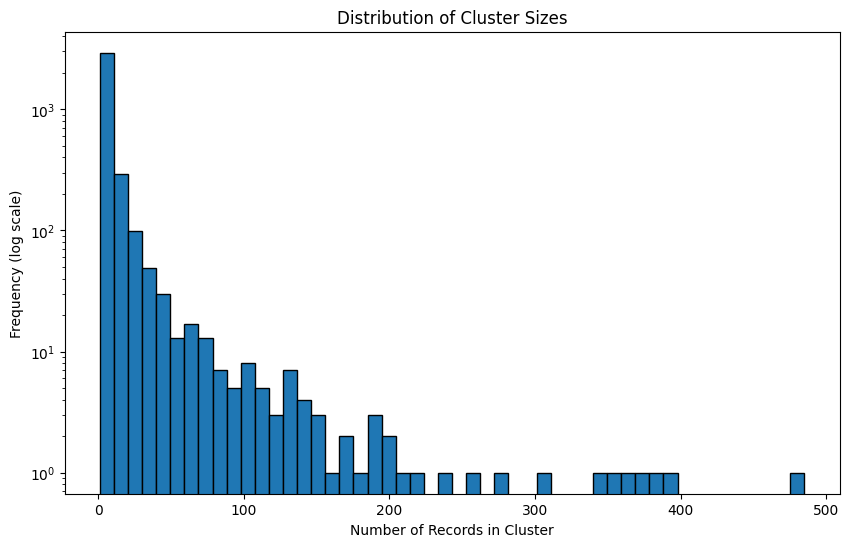

In [48]:
import matplotlib.pyplot as plt
cluster_sizes = df.groupby('unique_company_id').size()

print("Cluster size summary:")
print(cluster_sizes.describe())

plt.figure(figsize=(10, 6))
plt.hist(cluster_sizes, bins=50, log=True, edgecolor='black')
plt.title("Distribution of Cluster Sizes")
plt.xlabel("Number of Records in Cluster")
plt.ylabel("Frequency (log scale)")
plt.show()

In [50]:
def select_canonical_by_mode(records):

    mode_series = records['company_name'].mode()
    if len(mode_series) == 0:
        return records.iloc[0]
    else:
        common_name = mode_series.iloc[0]

    candidates = records[records['company_name'] == common_name]
    if candidates.empty:
        return records.iloc[0]
    return candidates.iloc[0]

canonical_records = df.groupby('unique_company_id').apply(select_canonical_by_mode)
canonical_records = canonical_records.reset_index(drop=True)

print("Sample canonical records by most used company name:")
print(canonical_records[['company_name', 'unique_company_id']].head())

canonical_records.to_csv('entity_resolution_canonical_mode.csv', index=False)
print("Canonical records saved as 'entity_resolution_canonical_mode.csv'.")

Sample canonical records by most used company name:
          company_name  unique_company_id
0  Dream Home Mortgage                  0
1  Headway East London                  1
2         Presto Pasta                  2
3      Ultra Petroleum                  3
4  Fairgrounds RV Park                  4
Canonical records saved as 'entity_resolution_canonical_mode.csv'.


C:\Users\theot\AppData\Local\Temp\ipykernel_21808\1023190018.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  canonical_records = df.groupby('unique_company_id').apply(select_canonical_by_mode)


Cluster size summary:
count    3497.000000
mean        9.564198
std        26.443270
min         1.000000
25%         1.000000
50%         5.000000
75%         7.000000
max       485.000000
dtype: float64


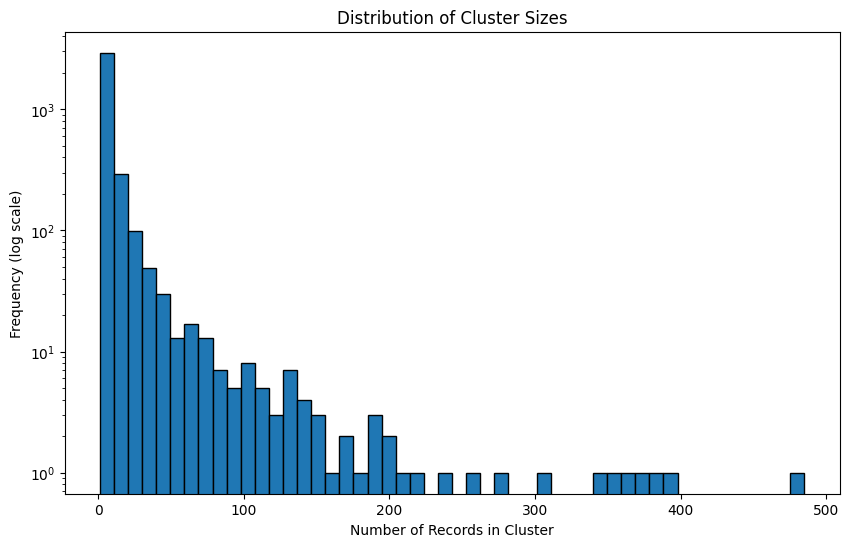

Unique clusters (single record): 1062
Duplicate clusters (multiple records): 2435


C:\Users\theot\AppData\Local\Temp\ipykernel_21808\4146860418.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=canonical_country_counts.values, y=canonical_country_counts.index, palette='viridis')


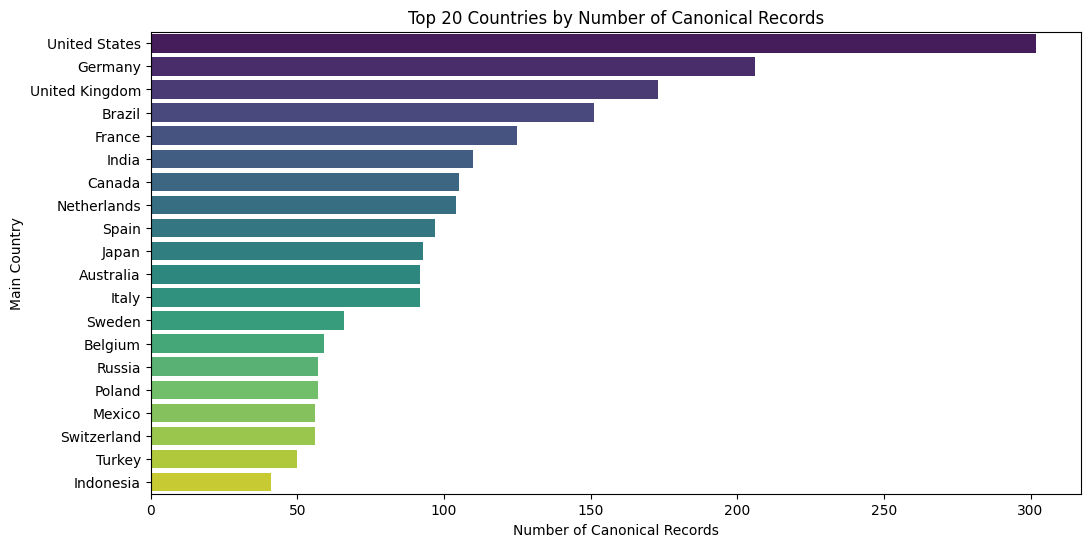

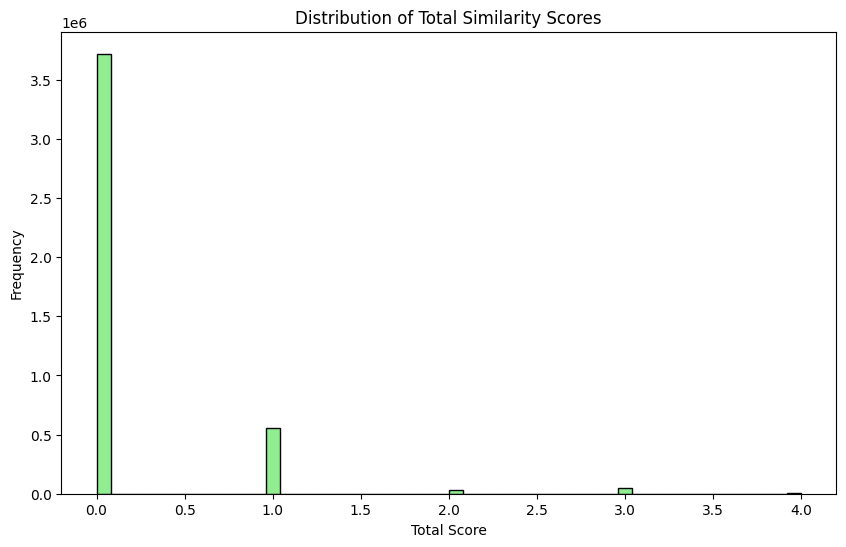

Top 10 columns with missing values:
tiktok_url                     33446
alexa_rank                     33446
ios_app_url                    33323
android_app_url                33308
naics_2022_secondary_codes     33202
naics_2022_secondary_labels    33202
other_emails                   32868
youtube_url                    32304
lnk_year_founded               31304
twitter_url                    30691
dtype: int64


In [51]:

import seaborn as sns

cluster_sizes = df.groupby('unique_company_id').size()
print("Cluster size summary:")
print(cluster_sizes.describe())

plt.figure(figsize=(10, 6))
plt.hist(cluster_sizes, bins=50, log=True, edgecolor='black')
plt.title("Distribution of Cluster Sizes")
plt.xlabel("Number of Records in Cluster")
plt.ylabel("Frequency (log scale)")
plt.show()

unique_clusters = (cluster_sizes == 1).sum()
duplicate_clusters = (cluster_sizes > 1).sum()
print(f"Unique clusters (single record): {unique_clusters}")
print(f"Duplicate clusters (multiple records): {duplicate_clusters}")


plt.figure(figsize=(12, 6))
canonical_country_counts = canonical_records['main_country'].dropna().value_counts().head(20)
sns.barplot(x=canonical_country_counts.values, y=canonical_country_counts.index, palette='viridis')
plt.title("Top 20 Countries by Number of Canonical Records")
plt.xlabel("Number of Canonical Records")
plt.ylabel("Main Country")
plt.show()


plt.figure(figsize=(10, 6))
plt.hist(features['total_score'], bins=50, color='lightgreen', edgecolor='black')
plt.title("Distribution of Total Similarity Scores")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.show()

missing_counts = df.isnull().sum().sort_values(ascending=False)
print("Top 10 columns with missing values:")
print(missing_counts.head(10))